In [1]:
#general
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,4)
import pandas as pd
pd.set_option('display.max_columns', 50)
import random

#preprocessing
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import category_encoders as ce
from scipy.stats import zscore

#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier

#model validation / evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## Model Evaluation Functions

In [2]:
def cm2df(cm, labels): 
    """converts a numpy array confusion matrix to a pandas dataframe, with class labels"""
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

def model_eval(y_test, y_pred): 
    """prints out a confusion matrix (pandas dataframe) and classification report"""
    conf_mat = confusion_matrix(y_test, y_pred)
    cm_as_df=cm2df(conf_mat,[0,1])
    new_names = {0:'Order Fail',1:'Order Success'}
    cm_as_df = cm_as_df.rename(index=new_names, 
                                 columns=new_names)
    print('\n')
    print('CONFUSION MATRIX (predicted along top, actual along side): ')
    display(cm_as_df)

    print('\n')
    print(classification_report(y_test,y_pred,target_names=['Order Fail','Order Success']))
    
def cross_validation(model, features, response, num_folds):
    metrics = ['precision_macro', 'recall_macro', "f1_macro"]
    cv = cross_validate(model, features, response, scoring=metrics, cv=num_folds)
    print("Test data set average precision across 5 folds:")
    print(cv['test_precision_macro'])
    print("\nTest data set average recall across 5 folds:")
    print(cv['test_recall_macro'])
    print("\nTest data set average fscore across 5 folds:")
    print(cv['test_f1_macro'])
    
def plot_roc_curve(model, X_test, y_test):
    probabilities = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, probabilities)
    print('AUC: %.3f' % auc)

    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    # plot no skill curve
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

# Preprocessing

In [3]:
def preprocess(df):
    success = df[df['ordersuccess']==1]
    fail = df[df['ordersuccess']==0]

    success_num = len(success)
    fail_num = len(fail)
    total = len(df)

    print('Number of order successes: ', success_num)
    print('Proportion of order successes: ', success_num / (success_num + fail_num))
    print('Number of order failures: ', fail_num)
    print('Proportion of order failures: ', fail_num / (success_num + fail_num))
    print('\n')
    
    def getTimeMS(t):
        if '.' in t:
            timestamp, ms = t.split('.')
        else:
            timestamp = t
            ms = 0
        time_obj = datetime.strptime(timestamp, '%H:%M:%S')
        epoch = datetime(1900, 1, 1, 0, 0, 0, 0)
        milliseconds = (time_obj - epoch) // timedelta(milliseconds=1)
        return milliseconds + float(ms)*1000

    df['time_ms'] = df['starttime'].apply(lambda x: getTimeMS(x))
    df['adv20d'] = df.loc[:,'adv20d'].fillna(0)


    #continuous features
    cont_features = df.loc[:,['time_ms','size','minexecqty','limitprice','prevailbid','prevailask','prevailbidsize','prevailasksize',
                              'dispatcherrebalance','lotsize','averagespread','misavgbidsize1min','misavgasksize1min', 
                              'misavgspread1min', 'misoddlotvolume1min', 'misadfvolume1min','misvolume1min', 'adv20d']]

    #one-hot encoded features
    dummies = pd.get_dummies(df.loc[:,['side','venuetype','securitycategory', 'peginstruction',
                                       'sector','mktcap']].astype('category'),drop_first=True)

    #binary encoded features
    enc = ce.BinaryEncoder()
    binary_sym = enc.fit_transform(df.loc[:,'symbol'].values)
    names = {'0_0':'symbol_0', '0_1':'symbol_1','0_2':'symbol_2','0_3':'symbol_3','0_4':'symbol_4',
             '0_5':'symbol_5','0_6':'symbol_6','0_7':'symbol_7','0_8':'symbol_8','0_9':'symbol_9',
             '0_10':'symbol_10','0_11':'symbol_11','0_12':'symbol_12'}
    binary_sym = binary_sym.rename(columns=names)

    binary_venue = enc.fit_transform(df.loc[:,'venue'].values)
    names = {'0_0':'venue_0', '0_1':'venue_1','0_2':'venue_2',
             '0_3':'venue_3','0_4':'venue_4','0_5':'venue_5','0_6':'venue_6'}
    binary_venue = binary_venue.rename(columns=names)


    features = pd.concat([cont_features, dummies, binary_sym, binary_venue], axis=1)
    response = df.loc[:,'ordersuccess']

    df = pd.concat([features,response],axis=1)
    
    df = df.sample(frac=1)
    train = df.head(round(total*.70))
    train = train.reset_index(drop=True)
    cont_features = ['time_ms','size','minexecqty','limitprice','prevailbid','prevailask','prevailbidsize','prevailasksize',
                          'dispatcherrebalance','lotsize','averagespread','misavgbidsize1min','misavgasksize1min', 
                          'misavgspread1min', 'misoddlotvolume1min', 'misadfvolume1min','misvolume1min', 'adv20d']
    scaler = StandardScaler().fit(train.loc[:,cont_features])
    Z_train = pd.DataFrame(scaler.transform(train.loc[:, cont_features]))
    train_categories = train[train.columns[~train.columns.isin(cont_features)]]   
    train_Z = pd.concat([Z_train, train_categories], axis=1)
    
    
    test = df.tail(round(total*.30))
    test = test.reset_index(drop=True)
    Z_test = pd.DataFrame(scaler.transform(test.loc[:, cont_features]))
    test_categories = test[test.columns[~test.columns.isin(cont_features)]]   
    test_Z = pd.concat([Z_test, test_categories], axis=1)
    

    train_success = train[train['ordersuccess']==1]
    train_success = train_success.reset_index(drop=True)
    train_fail = train[train['ordersuccess']==0]
    
    train_Z_success = train_Z[train_Z['ordersuccess']==1]
    train_Z_success = train_Z_success.reset_index(drop=True)
    train_Z_fail = train_Z[train_Z['ordersuccess']==0]
    
    return train, train_fail, train_success, test, train_Z, train_Z_fail, train_Z_success, test_Z

## Model Stacking

In [4]:
def model_stacking(train, train_fail, train_success, test, train_Z, train_Z_fail, train_Z_success, test_Z):
    def train_model(train_fail, train_success,  train_Z_fail, train_Z_success, sample):
        downsampled_fails = train_fail.loc[sample,:]
        downsampled_fails_Z = train_Z_fail.loc[sample, :]
        
        #recombine and shuffle data
        train_downsampled = pd.concat([downsampled_fails, train_success],axis=0)
        train_downsampled = train_downsampled.sample(frac=1).reset_index(drop=True)
        train_Z_downsampled = pd.concat([downsampled_fails_Z, train_Z_success], axis=0)
        train_Z_downsampled = train_Z_downsampled.sample(frac=1).reset_index(drop=True)

        #split into x and y
        train_features = train_downsampled.loc[:,train_downsampled.columns != 'ordersuccess']
        train_response = train_downsampled.loc[:,'ordersuccess']
        train_features_Z = train_Z_downsampled.loc[:,train_Z_downsampled.columns != 'ordersuccess']
        train_response_Z = train_Z_downsampled.loc[:,'ordersuccess']

        #train models
        RF = RandomForestClassifier()
        RF.fit(train_features, train_response)
        
        LR = AdaBoostClassifier(LogisticRegression())
        LR.fit(train_features, train_response)
        
        ANN = MLPClassifier()
        ANN.fit(train_features_Z, train_response_Z)
        
        NB = MultinomialNB()
        NB.fit(train_features, train_response)
        return RF, LR, ANN, NB

    train_features = train.loc[:,train.columns != 'ordersuccess']
    test_features = test.loc[:,test.columns != 'ordersuccess']
    test_features = test_features.reset_index(drop=True)
    train_features_Z = train_Z.loc[:,train_Z.columns != 'ordersuccess']
    test_features_Z = test_Z.loc[:,test_Z.columns != 'ordersuccess']
    test_features_Z = test_features_Z.reset_index(drop=True)


    new_features_train = pd.DataFrame({})
    new_features_test = pd.DataFrame({})
    indices_used = set()
    total_indices_train_fails = train_fail.index.tolist()
    successes = len(train_success)
    iterations = 0
    while len(indices_used) < 0.8*len(train_fail):
        iterations+=1
        sample = random.sample(total_indices_train_fails, len(train_success))
        indices_used.update(sample)
        RF, LR, ANN, NB = train_model(train_fail, train_success, train_Z_fail, train_Z_success, sample)
        
        #RF
        y_pred_train = pd.DataFrame(RF.predict(train_features))
        y_pred_train = y_pred_train.rename(columns={0:"RF Model %s" %iterations})
        new_features_train = pd.concat([new_features_train, y_pred_train], axis=1)
        y_pred_test = pd.DataFrame(RF.predict(test_features))
        y_pred_test = y_pred_test.rename(columns={0:"RF Model %s" %iterations})
        new_features_test = pd.concat([new_features_test, y_pred_test], axis=1)
        
        #LR
        y_pred_train = pd.DataFrame(LR.predict(train_features))
        y_pred_train = y_pred_train.rename(columns={0:"LR Model %s" %iterations})
        new_features_train = pd.concat([new_features_train, y_pred_train], axis=1)
        y_pred_test = pd.DataFrame(LR.predict(test_features))
        y_pred_test = y_pred_test.rename(columns={0:"LR Model %s" %iterations})
        new_features_test = pd.concat([new_features_test, y_pred_test], axis=1)
        
        #ANN
        y_pred_train = pd.DataFrame(ANN.predict(train_features_Z))
        y_pred_train = y_pred_train.rename(columns={0:"ANN Model %s" %iterations})
        new_features_train = pd.concat([new_features_train, y_pred_train], axis=1)
        y_pred_test = pd.DataFrame(ANN.predict(test_features_Z))
        y_pred_test = y_pred_test.rename(columns={0:"ANN Model %s" %iterations})
        new_features_test = pd.concat([new_features_test, y_pred_test], axis=1)
        
        #NB
        y_pred_train = pd.DataFrame(NB.predict(train_features))
        y_pred_train = y_pred_train.rename(columns={0:"NB Model %s" %iterations})
        new_features_train = pd.concat([new_features_train, y_pred_train], axis=1)
        y_pred_test = pd.DataFrame(NB.predict(test_features))
        y_pred_test = y_pred_test.rename(columns={0:"NB Model %s" %iterations})
        new_features_test = pd.concat([new_features_test, y_pred_test], axis=1)
        
        if iterations*4 % 16 == 0:
            print('Trained %s models' %(iterations*4))

    print('Total iterations', (iterations*4))
    train_features = pd.concat([train_features, new_features_train], axis=1)
    test_features = pd.concat([test_features, new_features_test], axis=1)

    train_response = train.loc[:,'ordersuccess']
    test_response = test.loc[:,'ordersuccess']
    test_response = test_response.reset_index(drop=True)
    
    return train_response, test_response, new_features_train, new_features_test

# Main

In [5]:
if __name__ == '__main__':
    df = pd.read_csv('data.csv')
    train, train_fail, train_success, test, train_Z, train_Z_fail, train_Z_success, test_Z = preprocess(df)
    train_response, test_response, new_features_train, new_features_test = model_stacking(train, train_fail, 
                                                                                            train_success, test, train_Z, 
                                                                                            train_Z_fail, train_Z_success, 
                                                                                            test_Z)

Number of order successes:  28190
Proportion of order successes:  0.05021044213331149
Number of order failures:  533247
Proportion of order failures:  0.9497895578666885


Trained 16 models
Trained 32 models
Trained 48 models
Trained 64 models
Trained 80 models
Trained 96 models
Trained 112 models
Total iterations 120


In [9]:
LR = LogisticRegression()
LR.fit(new_features_train, train_response)
y_pred = LR.predict(new_features_test)
model_eval(test_response, y_pred)



CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,156314,3671
Order Success,4487,3959




               precision    recall  f1-score   support

   Order Fail       0.97      0.98      0.97    159985
Order Success       0.52      0.47      0.49      8446

  avg / total       0.95      0.95      0.95    168431



In [10]:
ANN = MLPClassifier()
ANN.fit(new_features_train, train_response)
y_pred = ANN.predict(new_features_test)
model_eval(test_response, y_pred)



CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,156322,3663
Order Success,4526,3920




               precision    recall  f1-score   support

   Order Fail       0.97      0.98      0.97    159985
Order Success       0.52      0.46      0.49      8446

  avg / total       0.95      0.95      0.95    168431



IMPORTANT FEATURES SELECTED BY RANDOM FOREST: [(0.0649, 'RF Model 21'), (0.0622, 'RF Model 6'), (0.0563, 'RF Model 8'), (0.0497, 'RF Model 2'), (0.0477, 'RF Model 13'), (0.043, 'RF Model 4'), (0.0408, 'RF Model 3'), (0.0392, 'RF Model 15'), (0.0365, 'RF Model 1'), (0.0328, 'RF Model 16'), (0.0318, 'RF Model 23'), (0.0313, 'RF Model 14'), (0.0286, 'RF Model 26'), (0.0284, 'RF Model 19'), (0.0264, 'RF Model 17'), (0.0263, 'RF Model 27'), (0.0248, 'RF Model 30'), (0.0225, 'RF Model 25'), (0.0223, 'RF Model 29'), (0.0207, 'RF Model 22'), (0.0188, 'RF Model 9'), (0.0176, 'RF Model 18'), (0.0174, 'RF Model 24'), (0.0172, 'RF Model 7'), (0.0172, 'RF Model 28'), (0.0166, 'RF Model 11'), (0.0158, 'RF Model 5'), (0.0147, 'RF Model 12'), (0.0147, 'RF Model 10'), (0.0115, 'RF Model 20'), (0.0062, 'ANN Model 24'), (0.0034, 'ANN Model 30'), (0.0032, 'ANN Model 13'), (0.0031, 'ANN Model 18'), (0.003, 'ANN Model 6')]


CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,159665,320
Order Success,8282,164




               precision    recall  f1-score   support

   Order Fail       0.95      1.00      0.97    159985
Order Success       0.34      0.02      0.04      8446

  avg / total       0.92      0.95      0.93    168431

AUC: 0.933


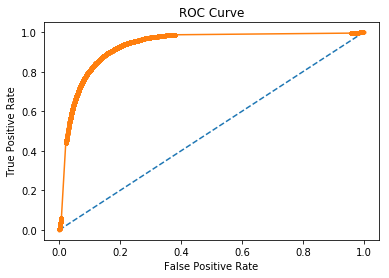

In [16]:
RF = RandomForestClassifier()
RF.fit(new_features_train, train_response)

#select top 35 features
important_features = sorted(zip(map(lambda x: round(x, 4), RF.feature_importances_), 
                                new_features_train.columns), reverse=True)[0:35]
print('IMPORTANT FEATURES SELECTED BY RANDOM FOREST:', important_features)

names = []
for i in important_features:
    names.append(i[1])

AB = AdaBoostClassifier(LogisticRegression())
AB.fit(new_features_train.loc[:, names], train_response)
y_pred = AB.predict(new_features_test.loc[:, names])
model_eval(test_response, y_pred)

plot_roc_curve(AB, new_features_test.loc[:,names], test_response)

# features = pd.concat([new_features_train, new_features_test], axis=0)
# response = pd.concat([train_response, test_response], axis=0)
# cross_validation(AB, features, response, 5)